**Goal of the project**

It’s easier to sell to an existing customer than it is to acquire a new one. For this reason, we want to ensure that our customers are satisfied with our product or service so that we can retain them long enough to recoup the investment required to earn their business in the first place.

The last thing we want is for customers to churn so that we continue to scramble for new business. One of the best ways to mitigate this is by measuring customer lifetime value (CLTV). Doing so will help our business acquire and retain highly valuable customers, which results in more revenue over time.

**Load the packages**

In [37]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import warnings

warnings.filterwarnings('ignore')

**Load the data**

In this project we’re going to use the UCI Machine Learning Repository’s [Online Retail Dataset](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci).

In [38]:
# Load dataset
df = pd.read_csv('../input/online-retail-ii-uci/online_retail_II.csv', parse_dates = ['InvoiceDate'])

In [39]:
# Rename Pandas columns to lower case
df.columns = df.columns.str.lower()

In [40]:
# Examine the data
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,"13,085.000",United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,"13,085.000",United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,"13,085.000",United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,"13,085.000",United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,"13,085.000",United Kingdom


In [41]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   invoice      1067371 non-null  object        
 1   stockcode    1067371 non-null  object        
 2   description  1062989 non-null  object        
 3   quantity     1067371 non-null  int64         
 4   invoicedate  1067371 non-null  datetime64[ns]
 5   price        1067371 non-null  float64       
 6   customer id  824364 non-null   float64       
 7   country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


**Check for missing values**

First, we look for records without an identifiable customer. We find as many as 243,007 of them.

In [42]:
# Check for missing values
df.isnull().sum()

invoice             0
stockcode           0
description      4382
quantity            0
invoicedate         0
price               0
customer id    243007
country             0
dtype: int64

In [43]:
# Remove records that lack a customer id
df.dropna(subset = ['customer id'], inplace = True)

**Removing negative values**

We observe negative quantities. These must have been product returns or cancellations. We need to remove their records.

In [44]:
df.describe()

,quantity,price,customer id
count,"824,364.000","824,364.000","824,364.000"
mean,12.415,3.677,"15,324.639"
std,188.976,70.241,"1,697.464"
min,"-80,995.000",0.000,"12,346.000"
25%,2.000,1.250,"13,975.000"
50%,5.000,1.950,"15,255.000"
75%,12.000,3.750,"16,797.000"
max,"80,995.000","38,970.000","18,287.000"


In [45]:
df = df[df['quantity'] > 0]

**Removing the time from a datetime**

To drop the time component from a column containing a datetime, we can use the Pandas to_datetime( ) function and then append .dt.date to extract only the date part.

In [46]:
df['invoicedate'] = df['invoicedate'].dt.date

**Correcting column data types**

As you can see from the output of df.info( ), the customer id field is being identified as a float64 when it should be an int64.

In [47]:
df['customer id'] = df['customer id'].astype(np.int64)

**Calculate the monetary value for each transaction**

To determine the monetary values of transactions — and later also the lifetime values of all customers — we insert a new column “total revenue” by multiplying the quantities with their corresponding unit prices.

In [48]:
df['total revenue'] = df['quantity'] * df['price']

**Drop unnecessary columns**

Calculating CLV only requires standard transactional data, comprising the customer id, the total value of the order and the order date. 

In [49]:
df = df[['customer id', 'total revenue', 'invoicedate']]

**Count the number of unique customers**

In [50]:
df['customer id'].nunique()

5881

**Calculate the raw recency, frequency, and monetary metrics**

The next step is to turn our raw transactional data into the recency, frequency, monetary and tenure (T) metrics we need to provide to the CLV models. While it’s relatively straightforward to do this manually using Pandas, there’s a really useful helper function in the Lifetimes package to do it for you called summary_data_from_transaction_data( ).

In [51]:
observation_period_end = df['invoicedate'].max()

In [52]:
df_rfmt = summary_data_from_transaction_data(transactions = df, 
                                             customer_id_col = 'customer id', 
                                             datetime_col = 'invoicedate', 
                                             monetary_value_col = 'total revenue', 
                                             observation_period_end = observation_period_end)

pd.options.display.float_format = '{:,.0f}'.format

df_rfmt

,frequency,recency,T,monetary_value
customer id,,,,
12346,7,400,725,"11,067"
12347,7,402,404,717
12348,4,363,438,449
12349,3,571,589,"1,120"
12350,0,0,310,0
...,...,...,...,...
18283,18,655,658,146
18284,0,0,431,0
18285,0,0,660,0


**Fit the BG/NBD model**

Lifetimes comes with a number of different models you can fit to your data. The first one we’ll try is the Beta Geometric Negative Binomial Distribution or BG/NBD model.

In [53]:
bgf = BetaGeoFitter(penalizer_coef = 0)

bgf.fit(frequency = df_rfmt['frequency'], 
        recency = df_rfmt['recency'], 
        T = df_rfmt['T'], 
        tol = 1e-6)

pd.options.display.float_format = '{:,.3f}'.format

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.663,0.016,0.632,0.694
alpha,63.185,1.935,59.393,66.977
a,0.109,0.015,0.078,0.139
b,2.418,0.525,1.389,3.447


**Predict the number of orders each customer will make during a time period**

Personally, I find the raw data much more interesting and useful than the visualisations, so let’s use the BG/NBD model data to predict the number of purchases each customer will make in some forthcoming periods.

We can do this by using the conditional_expected_number_of_purchases_up_to_time( ) and passing in the number of days to predict in the future t, the frequency data, the recency data and the T data showing tenure. We’ll set t to 90 so we predicted for the 90 days after the end of the observation period.

In [54]:
t = 90

df_rfmt['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t = t, 
                                                                                         frequency = df_rfmt['frequency'], 
                                                                                         recency = df_rfmt['recency'],
                                                                                         T = df_rfmt['T'])

**Compare the model’s predictions to the actual data**

Next we can assess how well the BetaGeoFitter BG/NBD model fits to our data. The plot_period_transactions( ) function will compare the actual observations from a previous time period to the model’s prediction for that time period. As you can see, the two are almost identical, which shows that the model is a very good fit and predicts the number of periods in the calibration period rather well.

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

<Figure size 576x432 with 0 Axes>

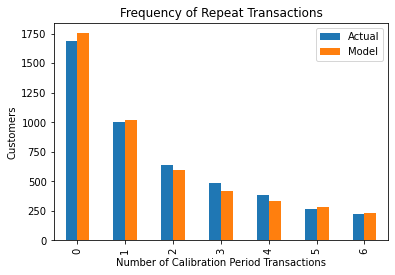

In [55]:
fig = plt.figure(figsize = (8, 6))
plot_period_transactions(model = bgf)

**Using a holdout group**

The other, more robust, approach to making predictions is to use a calibration period and a holdout or observation period. The calibration period starts from the date of the first transaction in our dataset and ends here on 2011-06-02. Immediately after this period the observation period starts, and this ends on 2011-12-09.

In [56]:
from datetime import timedelta

In [57]:
calibration_period_end = observation_period_end - timedelta(days = 190)

In [58]:
calibration_period_end

datetime.date(2011, 6, 2)

In [59]:
observation_period_end

datetime.date(2011, 12, 9)

In [60]:
summary_cal_holdout = calibration_and_holdout_data(transactions = df, 
                                                   customer_id_col = 'customer id', 
                                                   datetime_col = 'invoicedate',
                                                   monetary_value_col = 'total revenue',
                                                   calibration_period_end = calibration_period_end, 
                                                   observation_period_end = observation_period_end)

summary_cal_holdout.sort_values(by = 'frequency_holdout', ascending = False).head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer id,,,,,,,
14911,169.000,541.000,548.000,"1,125.525",85.000,25.653,190.000
12748,129.000,543.000,545.000,249.686,73.000,7.453,190.000
17841,124.000,545.000,547.000,329.769,68.000,5.104,190.000
15311,148.000,548.000,548.000,583.709,47.000,25.615,190.000
14606,137.000,545.000,546.000,185.259,43.000,4.057,190.000


**Re-fit the model on the calibration period**

Now we’ve got a dataset that’s partitioned into a calibration and validation or holdout period, we can re-fit the model just to the calibration data columns, frequency_cal, recency_cal and T_cal. The model now hasn’t seen any of the data for the holdout period.

In [61]:
bgf.fit(frequency = summary_cal_holdout['frequency_cal'], 
        recency = summary_cal_holdout['recency_cal'], 
        T = summary_cal_holdout['T_cal'], 
        tol = 1e-6)

<lifetimes.BetaGeoFitter: fitted with 4944 subjects, a: 0.16, alpha: 65.85, b: 3.41, r: 0.68>

Now that’s refitted, we can run plot_calibration_purchases_vs_holdout_purchases( ) to plot the predicted frequency of orders in the holdout period to the actual value. As you can see, the lines are pretty close together. The model is not far off at predicting the number of orders each customer will make.

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

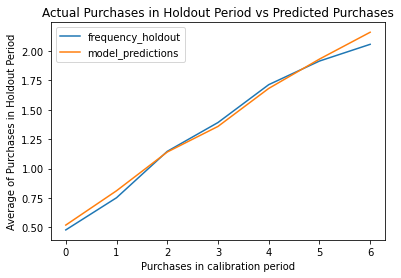

In [62]:
plot_calibration_purchases_vs_holdout_purchases(model = bgf, calibration_holdout_matrix = summary_cal_holdout)

**Predicting customer lifetime value**

Now that we’ve got the prediction of orders in the bag, let’s take a look at predicting their value. To do that we’ll use the Gamma-Gamma model.

We can use the original df_rfmt dataframe we created earlier for our training data. We’ll filter this to include only the returning customers.

In [63]:
returning_customers = df_rfmt[(df_rfmt['frequency'] > 0) & (df_rfmt['monetary_value'] > 0)]
returning_customers.sort_values(by = 'monetary_value', ascending = False).head()

,frequency,recency,T,monetary_value,predicted_purchases
customer id,,,,,
16446,1.000,205.000,205.000,"168,469.600",0.527
15749,1.000,97.000,332.000,"21,535.900",0.312
12346,7.000,400.000,725.000,"11,066.637",0.495
18102,66.000,738.000,738.000,"9,189.930",7.433
13902,4.000,92.000,724.000,"8,416.400",0.013


One really important point about the Gamma-Gamma model is that it assumes that monetary value and frequency are independent variables and aren’t correlated with each other.

In [64]:
returning_customers[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000,0.023
frequency,0.023,1.000


**Fit the Gamma-Gamma model**

Next we’ll fit the Gamma-Gamma model to the returning_customers dataframe we created above. We only need the frequency and monetary_value columns in order to fit the model, as we’re aiming to predict the monetary value of the orders they’ll place.

In [65]:
from lifetimes import GammaGammaFitter

In [66]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(frequency = returning_customers['frequency'], monetary_value = returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 2.13, q: 3.53, v: 486.53>

**Predict average order value**

If we run the conditional_expected_average_profit( ) function on the fitted ggf model you get back the predicted average order value for each customer. 

In [67]:
predicted_monetary = ggf.conditional_expected_average_profit(frequency = returning_customers['frequency'], monetary_value = returning_customers['monetary_value'])

Now we’ll take the Series returned by the above function and assign it to a dataframe, placing the predicted AOV value in its own column and leaving the customer_id value in the index. If we sort the aov column in descending order and reassign the sorted data back to the dataframe, you can then look at the top and bottom of your customer list.

In [68]:
aov_df = pd.DataFrame(predicted_monetary,columns = ['aov'])
aov_df = aov_df.sort_values(by = 'aov', ascending = False)
aov_df

,aov
customer id,
16446,"77,223.527"
15749,"10,065.630"
12346,"9,520.529"
18102,"9,034.694"
17450,"6,676.382"
...,...
17816,92.798
17888,92.640
17988,72.518


**Predicting Customer Lifetime Value**

Finally, we’ll get to the good bit - predicting Customer Lifetime Value. To do this we’ll use both models - the BG/NBD model to predict the number of orders and the Gamma-Gamma model to predict their values. First we’ll re-fit the BetaGeoFitter BG/NBD model to our dataset for the returning customers, which includes the monetary data.

In [69]:
bgf.fit(frequency = returning_customers['frequency'], 
        recency = returning_customers['recency'], 
        T = returning_customers['T'])

<lifetimes.BetaGeoFitter: fitted with 4189 subjects, a: 0.10, alpha: 104.61, b: 1.12, r: 1.54>

Next, we’ll use the Gamma-Gamma model’s customer_lifetime_value( ) function to predict their value. We’ll pass in the bgf model, along with the recency, frequency, monetary_value, and T data for each customers. The time parameter is in months and defines how many months into the future we wish to predict.

In [70]:
preds = ggf.customer_lifetime_value(transaction_prediction_model = bgf, 
                                    frequency = returning_customers['frequency'], 
                                    recency = returning_customers['recency'], 
                                    T = returning_customers['T'], 
                                    monetary_value = returning_customers['monetary_value'], 
                                    time = 12)

preds = preds.to_frame().reset_index()
preds.sort_values(by = 'clv', ascending = False).head()

,customer id,clv
4074,18102,"239,364.559"
1638,14646,"206,419.322"
2904,16446,"183,063.731"
3628,17450,"126,530.361"
1277,14156,"123,101.421"
